# 1. Pre-process data

In [38]:
# construct training data for the model
import json

# Function to read a .jsonl file
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Parse each line as JSON and append to the data list
            data.append(json.loads(line))
            # break
    return data

movies_meta_data = read_jsonl('./data/meta_Movies_and_TV.jsonl')

In [8]:
for movie in movies_meta_data:
    for key in movie.keys():
        print("{0}: {1}".format(key, movie[key]))
    print("*************************************************")
    print("title: {0}".format(movie['title']))
    print("description: {0}".format("".join(movie['description'])))
    break

main_category: Prime Video
title: Glee
subtitle: UnentitledUnentitled
average_rating: 4.7
rating_number: 2004
features: ['IMDb 6.8', '2013', '22 episodes', 'X-Ray', 'TV-14']
description: ['Entering its fourth season, this year the members of New Directions compete amongst themselves to be the "new Rachel" and hold auditions to find new students. Meanwhile, the graduating class leaves the comforts of McKinley where Rachel struggles to please her demanding NYADA teacher (Kate Hudson) and Kurt second-guesses his decision to stay in Lima. Four newcomers also join the musical comedy.']
price: 22.39
images: [{'360w': 'https://images-na.ssl-images-amazon.com/images/S/pv-target-images/8251ee0b9f888d262cd817a5f1aee0b29ffed56a4535af898b827292f881e169._RI_SX360_FMwebp_.jpg', '480w': 'https://images-na.ssl-images-amazon.com/images/S/pv-target-images/8251ee0b9f888d262cd817a5f1aee0b29ffed56a4535af898b827292f881e169._RI_SX480_FMwebp_.jpg', '720w': 'https://images-na.ssl-images-amazon.com/images/S/pv-

In [7]:
import json
# asins_small.json to be used for meta data matching
json_file_asins = './data/asins_small.json'
# json_file_asins = './data/meta_asins.json'
with open(json_file_asins, "r") as file:
    asin_dict = json.load(file)
    
asin_list = []
for asin in asin_dict:
    asin_list.append(asin)

In [9]:
movies_meta_data = []
for asin in asin_list:
    title = asin_dict[asin][0]
    description = "".join(asin_dict[asin][1])
    if title is None or title.strip() == "" or description is None or description.strip() == "":
        continue
    movies_meta_data.append({"title": title, "description": description})

In [10]:
movies_meta_data[0], len(movies_meta_data)

({'title': 'The Spitfire Grill',
  'description': 'Oscar-winner Ellen Burstyn (The Exorcist) headlines this critically praised drama about a young woman, just out of prison, who finds spiritual redemption working at a cafe in Maine.'},
 26846)

In [11]:
# load and setup the model and tokenizer
from unsloth import FastLanguageModel

max_seq_length = 4096
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-2b-it-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

def token_length(text):
    input_ids = tokenizer(text, return_tensors="pt").to("cuda")
    return len(input_ids[0])

prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"
prompt_template_token_length = token_length(prompt_template)
print("prompt_template_token_length: ", prompt_template_token_length)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
prompt_template_token_length:  11


In [12]:
# construct dataset
from datasets import Dataset
from tqdm import tqdm

prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"

encoding_title_to_desc_task = {"input": [], "output": []}
encoding_desc_to_title_task = {"input": [], "output": []}
for movie in tqdm(movies_meta_data):
    title_to_desc_task_prompt_template = "Here is the title of a movie: ```{0}```\n Please write a description of the movie."
    desc_to_title_task_prompt_template = "Here is a description of a movie: ```{0}```\n Please write the title of the movie."
    if token_length(title_to_desc_task_prompt_template.format(movie['title']) + "".join(movie['description'])) <= max_seq_length - prompt_template_token_length:
        encoding_title_to_desc_task["input"].append(title_to_desc_task_prompt_template.format(movie['title']))
        encoding_title_to_desc_task["output"].append("".join(movie['description']))
        encoding_desc_to_title_task["input"].append(desc_to_title_task_prompt_template.format("".join(movie['description'])))
        encoding_desc_to_title_task["output"].append(movie['title'])

encoding_title_to_desc_task = Dataset.from_dict(encoding_title_to_desc_task)
encoding_desc_to_title_task = Dataset.from_dict(encoding_desc_to_title_task)

# encoding_title_to_desc_task = encoding_title_to_desc_task.train_test_split(test_size=0.007)
# encoding_title_to_desc_task_dataset_train, encoding_title_to_desc_task_dataset_eval = encoding_title_to_desc_task["train"], encoding_title_to_desc_task["test"]
# encoding_desc_to_title_task = encoding_desc_to_title_task.train_test_split(test_size=0.007)
# encoding_desc_to_title_task_dataset_train, encoding_desc_to_title_task_dataset_eval = encoding_desc_to_title_task["train"], encoding_desc_to_title_task["test"]

100%|██████████| 26846/26846 [00:44<00:00, 603.85it/s]


In [13]:
encoding_title_to_desc_task, encoding_desc_to_title_task, # before length filtering, num_rows = 434236
# encoding_title_to_desc_task_dataset_train, encoding_title_to_desc_task_dataset_eval, encoding_desc_to_title_task_dataset_train, encoding_desc_to_title_task_dataset_eval

(Dataset({
     features: ['input', 'output'],
     num_rows: 26837
 }),
 Dataset({
     features: ['input', 'output'],
     num_rows: 26837
 }))

In [14]:
# save huggingface dataset to local
encoding_title_to_desc_task.save_to_disk('./data/encoding_title_to_desc_task_fixed_empty_string_filter')
encoding_desc_to_title_task.save_to_disk('./data/encoding_desc_to_title_task_fixed_empty_string_filter')

Saving the dataset (0/1 shards):   0%|          | 0/26837 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/26837 [00:00<?, ? examples/s]

Map:   0%|          | 0/434213 [00:00<?, ? examples/s]

100%|██████████| 434213/434213 [05:26<00:00, 1328.77it/s]


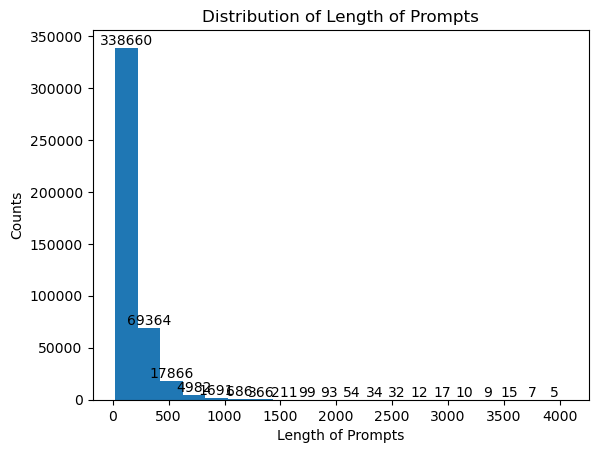

In [13]:
# Get the distribution of length of (input + output) text in training dict
import matplotlib.pyplot as plt
from tqdm import tqdm

encoding_title_to_desc_task_combined = encoding_title_to_desc_task.map(lambda x: {"combined_text": x["input"] + x["output"]})

length_of_input_plus_output = []
for text in tqdm(encoding_title_to_desc_task_combined['combined_text']):
    length_of_input_plus_output.append(token_length(text))

# Create the histogram and get the number of occurrences and the bin edges
counts, bins, patches = plt.hist(length_of_input_plus_output, bins=20)

# Loop over the patches (bars) and add a text label above each bar
for count, bin, patch in zip(counts, bins, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 5, str(int(count)),
             ha='center', va='bottom')

plt.xlabel('Length of Prompts')
plt.ylabel('Counts')
plt.title('Distribution of Length of Prompts')
plt.show()

# 2. Training Encoding model

In [7]:
import json
from datetime import datetime

import torch
from datasets import load_from_disk
from unsloth import FastLanguageModel

hyper_params = {
    # Model hyperparameters
    "max_seq_length": 4096, # 8192 | Choose any! We auto support RoPE Scaling internally!
    "dtype": None, # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    "load_in_4bit": True, # Use 4bit quantization to reduce memory usage. Can be False.,
    "model_name": "unsloth/gemma-2b-it-bnb-4bit",
    "r": 8, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128,
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # Add more to target more modules
    "lora_alpha": 16,
    "lora_dropout": 0, # Supports any, but = 0 is optimized
    "lora_bias": "none", # Supports any, but = "none" is optimized
    "lora_use_gradient_checkpointing": "unsloth", # True or "unsloth" for very long context
    "lora_random_state": 3407,
    "lora_use_rslora": False, # We support rank stabilized LoRA
    "lora_loftq_config": None, # And LoftQ
    # Training hyperparameters
    "encoding_title_to_desc_task_path": "./data/encoding_title_to_desc_task",
    "encoding_desc_to_title_task_path": "./data/encoding_desc_to_title_task",
    "per_device_train_batch_size": 2,
    "gradient_accumulation_steps": 1,
    "warmup_steps": 25, # will replace num_warmup_steps in lr_scheduler_kwargs
    "num_train_epochs": 2,
    "learning_rate": 2e-4,
    "fp16": not torch.cuda.is_bf16_supported(),
    "bf16": torch.cuda.is_bf16_supported(),
    "logging_steps": 1,
    "optim": "adamw_8bit",
    "weight_decay": 0.01,
    "lr_scheduler_type": "cosine_with_restarts",
    "lr_scheduler_kwargs": {"num_cycles": 3}, # "num_warmup_steps" and "num_training_steps" will be added automatically
    "seed": 3407,
}

In [5]:
# load model and tokenizer
model, tokenizer= FastLanguageModel.from_pretrained(
    model_name = hyper_params["model_name"], # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = hyper_params["max_seq_length"],
    dtype = hyper_params["dtype"],
    load_in_4bit = hyper_params["load_in_4bit"],
)

==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


In [6]:
# add lora to model
model = FastLanguageModel.get_peft_model(
    model,
    r = hyper_params['r'],
    target_modules = hyper_params['target_modules'],
    lora_alpha = hyper_params['lora_alpha'],
    lora_dropout = hyper_params['lora_dropout'],
    bias = hyper_params['lora_bias'],
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = hyper_params['lora_use_gradient_checkpointing'],
    random_state = hyper_params['lora_random_state'],
    use_rslora = hyper_params['lora_use_rslora'], # We support rank stabilized LoRA
    loftq_config = hyper_params['lora_loftq_config'], # And LoftQ
)

Unsloth 2024.4 patched 18 layers with 18 QKV layers, 18 O layers and 18 MLP layers.


## 2.1 Train encoding_title_to_desc_task

In [13]:
# read huggingface dataset from local
encoding_title_to_desc_task = load_from_disk(hyper_params["encoding_title_to_desc_task_path"])

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

prompt_template = prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"

def formatting_prompts_func(examples):
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []

    for input, output in zip(inputs, outputs):
        # text = "### Input:\n{inputs_holder}\n\n### Response:{outputs_holder}".format(inputs_holder= input, outputs_holder= output) + EOS_TOKEN
        # gemma chat template:
        text = prompt_template.format(input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

train_dataset = encoding_title_to_desc_task.map(formatting_prompts_func, batched = True,)
# train_dataset = encoding_desc_to_title_task.map(formatting_prompts_func, batched = True,)

# take samples from the dataset
train_dataset = train_dataset.shuffle(seed=hyper_params["seed"])
train_dataset = train_dataset.select(range(100))

In [14]:
# training
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    # eval_dataset = test_dataset,
    dataset_text_field = "text",
    max_seq_length = hyper_params['max_seq_length'],
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = hyper_params['per_device_train_batch_size'],
        gradient_accumulation_steps = hyper_params['gradient_accumulation_steps'],
        warmup_steps = hyper_params['warmup_steps'],
        num_train_epochs = hyper_params['num_train_epochs'],
        # max_steps = 100,
        learning_rate = hyper_params['learning_rate'],
        fp16 = hyper_params['fp16'],
        bf16 = hyper_params['bf16'],
        logging_steps = hyper_params['logging_steps'],
        optim = hyper_params['optim'],
        weight_decay = hyper_params['weight_decay'],
        lr_scheduler_type = hyper_params['lr_scheduler_type'],
        lr_scheduler_kwargs = hyper_params['lr_scheduler_kwargs'],
        seed = hyper_params['seed'],
        output_dir = "outputs",
        # fp16_full_eval = True,
        # per_device_eval_batch_size = 1,
        # eval_accumulation_steps = 1,
        # evaluation_strategy = "steps", # epoch
        # eval_steps = 100,
    ),
)

Map (num_proc=2):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 100 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 1
\        /    Total batch size = 2 | Total steps = 100
 "-____-"     Number of trainable parameters = 9,805,824


Step,Training Loss
1,6.863800
2,6.494600
3,6.115700
4,5.545300
5,5.275700
6,5.773700
7,4.764100
8,4.283300
9,3.856800
10,5.017600


In [11]:
# saving model and loss history
# get current datetime
now = datetime.now()

# name the model
model_name = "e_t2d_model_" + now.strftime("%m%d%Y_%H%M%S")
model_path = "outputs/" + model_name
model.save_pretrained(model_path) # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

# save hyperparameters as a json dict to model_path
with open(model_path + "/hyperparameters.json", "w") as file:
    json.dump(hyper_params, file, indent=4)
        
# save trainer.state.log_history to model_path
with open(model_path + "/trainer_state_log_history.json", "w") as file:
    json.dump(trainer.state.log_history, file, indent=4)

## 2.2 Train encoding_desc_to_title_task

In [ ]:
# clear the cache
import torch

torch.cuda.empty_cache()

In [15]:
# similarly, we can train the model for encoding_desc_to_title_task......
# read huggingface dataset from local
encoding_desc_to_title_task = load_from_disk(hyper_params["encoding_desc_to_title_task_path"])

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

prompt_template = prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"

def formatting_prompts_func(examples):
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []

    for input, output in zip(inputs, outputs):
        # text = "### Input:\n{inputs_holder}\n\n### Response:{outputs_holder}".format(inputs_holder= input, outputs_holder= output) + EOS_TOKEN
        # gemma chat template:
        text = prompt_template.format(input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

train_dataset = encoding_desc_to_title_task.map(formatting_prompts_func, batched = True,)

# take samples from the dataset
train_dataset = train_dataset.shuffle(seed=hyper_params["seed"])
train_dataset = train_dataset.select(range(100))

Map:   0%|          | 0/434213 [00:00<?, ? examples/s]

In [16]:
# training
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    # eval_dataset = test_dataset,
    dataset_text_field = "text",
    max_seq_length = hyper_params['max_seq_length'],
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = hyper_params['per_device_train_batch_size'],
        gradient_accumulation_steps = hyper_params['gradient_accumulation_steps'],
        warmup_steps = hyper_params['warmup_steps'],
        num_train_epochs = hyper_params['num_train_epochs'],
        # max_steps = 100,
        learning_rate = hyper_params['learning_rate'],
        fp16 = hyper_params['fp16'],
        bf16 = hyper_params['bf16'],
        logging_steps = hyper_params['logging_steps'],
        optim = hyper_params['optim'],
        weight_decay = hyper_params['weight_decay'],
        lr_scheduler_type = hyper_params['lr_scheduler_type'],
        lr_scheduler_kwargs = hyper_params['lr_scheduler_kwargs'],
        seed = hyper_params['seed'],
        output_dir = "outputs",
        # fp16_full_eval = True,
        # per_device_eval_batch_size = 1,
        # eval_accumulation_steps = 1,
        # evaluation_strategy = "steps", # epoch
        # eval_steps = 100,
    ),
)

Map (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

In [17]:
trainer_stats = trainer.train()

Step,Training Loss
1,3.218400
2,3.286000
3,3.059500
4,3.000300
5,2.343000
6,2.728500
7,2.932600
8,3.518000
9,2.929600
10,2.752800


In [18]:
# saving model and loss history
# get current datetime
now = datetime.now()

# name the model
model_name = "e_d2t_model_" + now.strftime("%m%d%Y_%H%M%S")
model_path = "outputs/" + model_name
model.save_pretrained(model_path) # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

# save hyperparameters as a json dict to model_path
with open(model_path + "/hyperparameters.json", "w") as file:
    json.dump(hyper_params, file, indent=4)
        
# save trainer.state.log_history to model_path
with open(model_path + "/trainer_state_log_history.json", "w") as file:
    json.dump(trainer.state.log_history, file, indent=4)

# 3. Inference

In [31]:
# read eval dataset from local
from datasets import load_from_disk

dataset_eval = load_from_disk("./data/encoding_title_to_desc_task")

# dataset_eval.num_rows
# index_i = 6
index_i = 0
dataset_eval[index_i]['input'], \
dataset_eval[index_i]['output']

('Here is the title of a movie: ```Glee```\n Please write a description of the movie.',
 'Entering its fourth season, this year the members of New Directions compete amongst themselves to be the "new Rachel" and hold auditions to find new students. Meanwhile, the graduating class leaves the comforts of McKinley where Rachel struggles to please her demanding NYADA teacher (Kate Hudson) and Kurt second-guesses his decision to stay in Lima. Four newcomers also join the musical comedy.')

In [34]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"

def formatting_prompts_func(examples):
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []

    for input, output in zip(inputs, outputs):
        # text = "### Input:\n{inputs_holder}\n\n### Response:{outputs_holder}".format(inputs_holder= input, outputs_holder= output) + EOS_TOKEN
        # gemma chat template:
        text = prompt_template.format(input, output) + EOS_TOKEN
        texts.append(text)
        print(output)
        break
    return { "text" : texts, }

train_dataset = dataset_eval.map(formatting_prompts_func, batched = True,)

# take samples from the dataset
train_dataset = train_dataset.shuffle(seed=3407)
train_dataset = train_dataset.select(range(15000))

Map:   0%|          | 0/434213 [00:00<?, ? examples/s]

Entering its fourth season, this year the members of New Directions compete amongst themselves to be the "new Rachel" and hold auditions to find new students. Meanwhile, the graduating class leaves the comforts of McKinley where Rachel struggles to please her demanding NYADA teacher (Kate Hudson) and Kurt second-guesses his decision to stay in Lima. Four newcomers also join the musical comedy.


ArrowInvalid: Column 2 named text expected length 1000 but got length 1

In [35]:
train_dataset[178]

{'input': 'Here is the title of a movie: ```The Mule [Blu-ray] [2019]```\n Please write a description of the movie.',
 'output': "Clint Eastwood stars as Earl Stone, a man in his 80s who is broke, alone, and facing foreclosure of his business when he is offered a job that simply requires him to drive. Easy enough, but, unbeknownst to Earl, he's just signed on as a drug courier for a Mexican cartel. He does well-so well, in fact, that his cargo increases exponentially, and Earl is assigned a handler. But he isn't the only one keeping tabs on Earl; the mysterious new drug mule has also hit the radar of hard-charging DEA agent Colin Bates. And even as his money problems become a thing of the past, Earl's past mistakes start to weigh heavily on him, and it's uncertain if he'll have time to right those wrongs before law enforcement, or the cartel's enforcers, catch up to him.",
 'text': "<start_of_turn>user\nHere is the title of a movie: ```The Mule [Blu-ray] [2019]```\n Please write a desc

In [19]:
# check the training results
title_to_desc_task_prompt_template = "Here is the title of a movie: ```{0}```\n Please write a description of the movie."
desc_to_title_task_prompt_template = "Here is a description of a movie: ```{0}```\n Please write the title of the movie."
    
test_input = title_to_desc_task_prompt_template.format("Glee")

In [22]:
from transformers import TextStreamer, GenerationConfig
from unsloth import FastLanguageModel
import torch

max_seq_length = 4096 # 8192 | Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
    
model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "outputs/model_04242024_090830/", # YOUR MODEL YOU USED FOR TRAINING
    # model_name = "unsloth/gemma-2b-it-bnb-4bit",
    # model_name = "outputs/checkpoint-1000",
    model_name = "outputs/e_t2d_model_05142024_084000",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
        
prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}"
inputs = tokenizer(
[
    # "### Input:\n{inputs}\n\n### Response:{outputs}".format(inputs= input, outputs= ""),
    # "{inputs}".format(inputs= input),
    prompt_template.format(test_input, ""),    
], return_tensors = "pt").to("cuda")

num_beams_parameter = 5
custom_generation_config = GenerationConfig(
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    asin_dict=None,
    tokenizer=tokenizer,
    return_dict_in_generate=True,
    output_scores=True,
    # output_logits=True,
    do_sample=True,
    early_stopping=True,
    num_beams=num_beams_parameter, 
    num_return_sequences=num_beams_parameter,
    max_new_tokens=35,
    use_cache=True,
    temperature=1,
    # num_beam_groups=5, # In this generation mode, `num_beams` should be divisible by `num_beam_groups`. `diversity_penalty` is not 0.0 or `num_beam_groups` is not 1, triggering group beam search. 
    # diversity_penalty=0.9, # `diversity_penalty` should be greater than `0.0`, otherwise your groups will be identical.
    output_hidden_states=True,
)

# inputs = tokenizer(
# [
#     prompt_template.format(input, ""),    
# ], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, generation_config=custom_generation_config)

# check CUDA memory usage
used_memory = round(torch.cuda.max_memory_allocated() / 1024 / 1024 / 1024, 3)
# if used_memory close to 14GB, empty the cache
if used_memory > 1:
    torch.cuda.empty_cache()
    print("CUDA memory usage is high. Cleared the cache.")

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
CUDA memory usage is high. Cleared the cache.


In [23]:
for i in range(num_beams_parameter):
    # print(outputs['sequences'][i])
    print("Generated text: ", "".join(tokenizer.decode(outputs['sequences'][i], skip_special_tokens=True)))
    print("*************************************************")
# print("Hidden states: ", outputs['hidden_states'])
# print("*************************************************")

Generated text:  user
Here is the title of a movie: ```Glee```
 Please write a description of the movie.
model
Glee
- Season 1
- 1-disc box set
*************************************************
Generated text:  user
Here is the title of a movie: ```Glee```
 Please write a description of the movie.
model
Glee
*************************************************
Generated text:  user
Here is the title of a movie: ```Glee```
 Please write a description of the movie.
model
Glee
*************************************************
Generated text:  user
Here is the title of a movie: ```Glee```
 Please write a description of the movie.
model
Glee
- Season 2
*************************************************
Generated text:  user
Here is the title of a movie: ```Glee```
 Please write a description of the movie.
model
Glee
- Season 5
*************************************************


# 4. Predicting model

## 4.1 construct training dataset

## 4.2 Distance based loss function - training